We begin by loading in the data.
(Make sure to use the latest version of Connectome-Utilities from:
github.com:openbraininstitute/ConnectomeUtilities.git
This latest version has not been deployed on pypi yet!)

In [1]:
import numpy
import pandas
import conntility
import h5py
import scipy

fn = "../datasets/mystery_con_mats.h5"

data = conntility.ConnectivityGroup.from_h5(fn)

The result is a ConnectivityGroup object. That is, a bundle of connectivity matrices that can be analyzed together.
The matrices are grouped into different groups: "mystery_1" to "mystery_7". Each has been generated by a different algorithm, one of them is the original.

The .index tells you what each matrix belongs to. 

In [25]:
display(data.index)

MultiIndex([('mystery_1',   0),
            ('mystery_1',   1),
            ('mystery_1',   2),
            ('mystery_1',   3),
            ('mystery_1',   4),
            ('mystery_1',   5),
            ('mystery_1',   6),
            ('mystery_1',   7),
            ('mystery_1',   8),
            ('mystery_1',   9),
            ...
            ('mystery_7', 167),
            ('mystery_7', 168),
            ('mystery_7', 169),
            ('mystery_7', 170),
            ('mystery_7', 171),
            ('mystery_7', 172),
            ('mystery_7', 173),
            ('mystery_7', 174),
            ('mystery_7', 175),
            ('mystery_7', 176)],
           names=['matrix_type', 'matrix_number'], length=1239)

Use the regular indexing operation to access individual matrices.

the .vertices are the properties associated with each vertex, i.e., neuron, such as their locations and distance from the pia.

.array depicts the adjacency matrix: Zero values indicate absence of a connection, nonzero values indicate the strength of a connection.

In [26]:
mat = data["mystery_1", 0]
display(mat.array, mat.vertices)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.29316389,  0.        ,  0.        ,
         0.2180655 ,  0.        ,  0.06505472],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.40020695,  0.        ,  0.        ],
       [ 0.        ,  0.13715781,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.07192078,  0.        ,  0.        ,  0.        ,
         0.        ,  0.19575158,  0.        ],
       [-0.02566264,  0.        ,  0.81573342,  0.        ,  0.        ,
         0.        ,  0.        ,  0.35626405],
       [ 0.        ,  0.3115725 ,  0.11634439,  0.29981385,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.81562587,  0.        ,
         0.        ,  0.        ,  0.        ]])

,index,piadistance,coordinate_1,coordinate_2,coordinate_3
0,0,663.667454,257.542419,208.023732,-39.237352
1,1,514.681202,76.110088,184.936457,-40.504739
2,2,672.771559,210.675332,106.368466,-43.054271
3,3,492.133745,32.651953,137.122430,-41.125907
4,4,554.056993,167.743892,306.794794,-10.205932
5,5,499.092137,110.130334,285.867990,-33.180026
6,6,609.784949,139.132016,72.025959,-38.610418
7,7,551.067207,54.340993,77.297903,-32.443477


You can convert them to a *networkx* graph and use that for example for plotting.

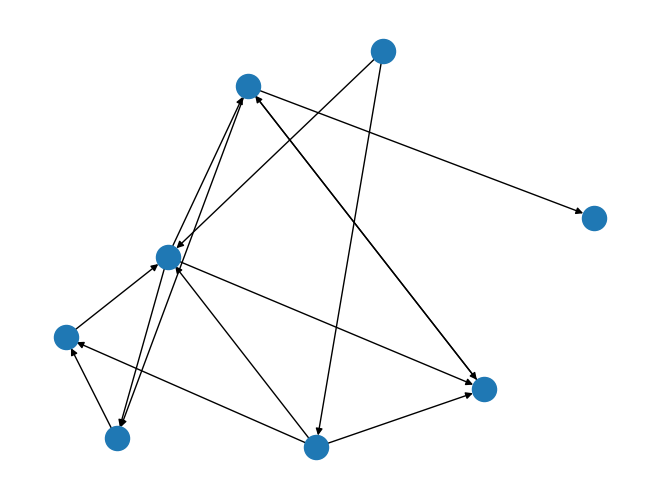

In [21]:
import networkx

def draw_graph(graph, coords=["coordinate_1", "coordinate_2"], **kwargs):
      pos = dict([(k, [v[_c] for _c in coords])
                  for k, v in graph.nodes.items()])
      networkx.draw(graph, pos=pos, **kwargs)

graph = data["mystery_1", 0].to_networkx()
draw_graph(graph)


## Which one's the original?

### Part 1: The mean amplitude of connections is 0.64 mV
We know that in the original data the mean amplitude is 0.64 mV. We can test which of the mystery connectomes match this.

First, we write a function that takes as inputs:
 - The adjacency matrix of a connectome as a scipy.sparse matrix
 - A pandas.DataFrame of the node properties
and returns a Series of connection amplitude values. We reference this function is a basic analysis recipe so that it can be conveniently applied to all matrices.

The we test the extracted distributions to the expected mean, separately for each type of matrix (.groupby) 

In [ ]:
def edge_values(mat, nodes):
    vals = pandas.Series(mat.data)
    return vals[~numpy.isnan(vals)]

analysis = {
    "analyses": {
        "connection_strengths": {
            "source": edge_values,
            "output": "Series"
        }
    }
}
# Apply the analysis function to all matrices in the group.
result = data.analyze(analysis)

# Wrapper for a statistical test of amplitudes against the expected value
mean_strength_matches = lambda samples: scipy.stats.ttest_1samp(samples, 0.64).pvalue >= 0.05
# Compare distributions separately for all matrix_types.
display(result["connection_strengths"].groupby("matrix_type").apply(mean_strength_matches))

matrix_type
mystery_1     True
mystery_2     True
mystery_3    False
mystery_4     True
mystery_5     True
mystery_6     True
mystery_7     True
dtype: bool

### Part 2: The connection probability is 0.158

We know the mean connection probability of the data (0.158). Similar to the above, we extract connection probabilities and compare the distribution of results to this value.

In [29]:
def connection_probability(mat, nodes):
    # Fill in a function that returns the connection probability as a single, float value between 0 and 1.
    # Warning: There are empty (0 nodes) matrices in the data.analyze
    return numpy.nan


analysis["analyses"]["connection_probability"] = {
    "source": connection_probability,
    "output": "Value"
}
# Apply the analysis functions to all matrices in the group.
result = data.analyze(analysis)

# Wrapper for a statistical test of amplitudes against the expected value
mean_prob_matches = lambda samples: scipy.stats.ttest_1samp(samples, 0.158).pvalue >= 0.05
# Compare distributions separately for all matrix_types.
display(result["connection_probability"].dropna().groupby("matrix_type").apply(mean_strength_matches))

Series([], dtype: float64)

To be continued